In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.preprocessing import normalize
import numpy as np
from tools import *

# Partie 1 : SIFT

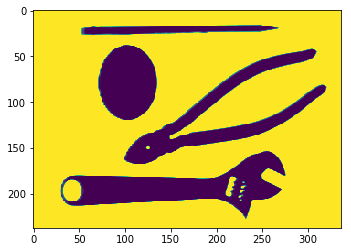

In [2]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

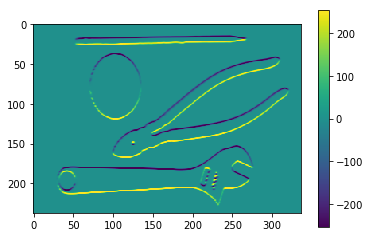

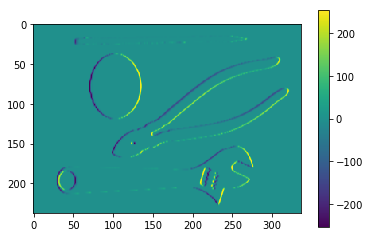

In [3]:
def compute_grad(I):
    hb = 0.5*np.array([-1,0,1])
    ha = 0.5*np.array([1,2,1])
    Ix = conv_separable(I, ha, hb)
    Iy = conv_separable(I, hb, ha)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [4]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gm = np.sqrt(Ix**2 + Iy**2)     #norme du gradient
    Go = compute_grad_ori(Ix, Iy, Gm)      #orientation discrétisée
    return Gm, Go

In [5]:
def compute_sift_region(Gm, Go, mask=None):
    
    # Note: to apply the mask only when given, do:
    if mask is not None:
        G_pond = Gm*mask
    else:
        G_pond = Gm
    Renc = np.zeros((16,8))
    for i in range(len(Gm)):
        for j in range(len(Gm[0])):
            Renc[i%4+j%4][Go[i,j]] += G_pond[i,j]
    Penc = np.reshape(np.array(Renc), 128)
    n = np.linalg.norm(Penc)
    if (n <= 0.5):
        return np.zeros(128)
    else:
        Penc /= n
    Penc[Penc>0.2] = 0.2
    n = np.linalg.norm(Penc)
    Penc /= n
    return Penc

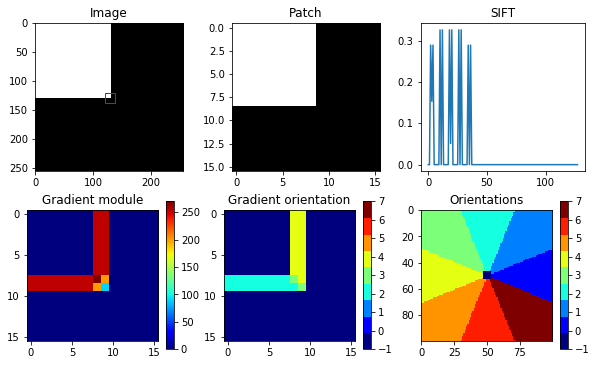

array([ 0.        ,  0.        ,  0.28938201,  0.15346799,  0.28938201,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.32630835,  0.        ,  0.32630835,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.32630835,  0.051156  ,
        0.32630835,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.32630835,  0.        ,  0.32630835,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.28938201,
        0.        ,  0.28938201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [6]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
#display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [7]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    
    # TODO calculs communs aux patchs
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            Gm, Go = compute_grad_mod_ori(I[xi:xi+16, yj:yj+16])
            sifts[i, j, :] =  compute_sift_region(Gm, Go)# TODO SIFT du patch de coordonnee (xi, yj)
    return sifts

# Partie 2 : Dictionnaire visuel

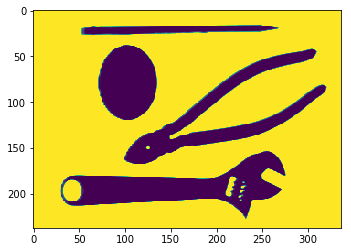

In [8]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *
from sklearn.cluster import KMeans

In [9]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [10]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [29]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, verbose=verbose, max_iter=30).fit(sift)
    cluster = kmeans.cluster_centers_
    #print(cluster[0])
    cluster = np.append(cluster, np.zeros((1,len(cluster[0]))), axis=0)
    return cluster

In [16]:
## Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

Computing or loading visual dict


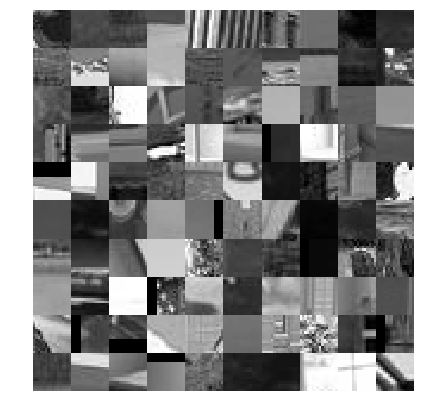

In [17]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 100)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

In [18]:
def distance_sift_cent(c, sifts, nb_proche):
    dist =[]
    for s in sifts:
        dist.append(sum((c-s)**2))
    min_dist = np.argsort(dist)
    
    return np.sort(min_dist[:nb_proche])

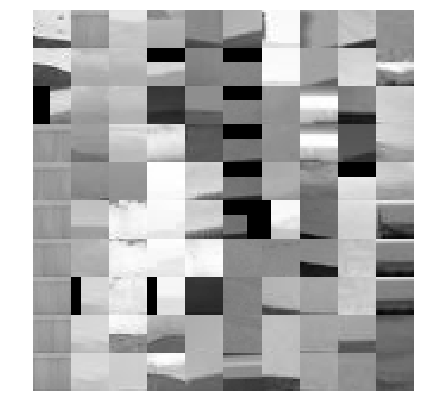

In [24]:
# TODO visually analyze the dict through similar example regions
ind = distance_sift_cent(vdict[6], sifts, 100)
display_images(regions[ind])

In [25]:
def construc_vdregion(vdict, sifts):
    vdregions = []
    for c in range(len(vdict)):
        vdregions.append(regions[distance_sift_cent(vdict[c], sifts, 1)].reshape(16,16))
    return vdregions

In [17]:
#vdregions = construc_vdregion(vdict, sifts)

In [26]:
%store -r

In [21]:
#%store vdregions

Stored 'vdregions' (ndarray)


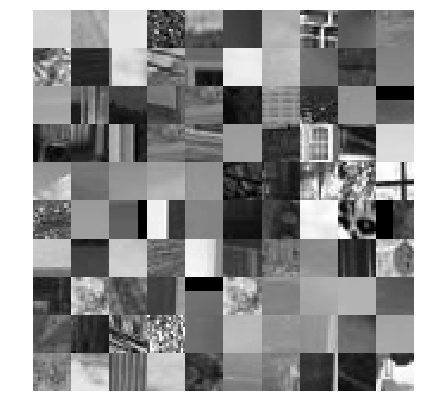

In [27]:
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center
vdregions = np.array(vdregions)
display_images(np.array(vdregions[:100]))

# Partie 3 : BoW

In [30]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    images=image_sifts.reshape(-1,image_sifts.shape[2])
    #multiplication matricielle entre vdict et image_sifts
    
    normC=np.repeat([np.sum(vdict**2,axis=1)],len(images),axis=0).T
    mat = -2*np.dot(vdict, images.T) + normC
    
    #coding
    H = np.zeros((len(mat), len(mat[0])))
    argmin=np.argmin(mat,axis=0)
    H[list(argmin),range(len(H[0]))]=1
    
    #pooling
    Z=np.sum(H,axis=1)
    Z=Z/sum(Z)    #normalisation    
    return Z

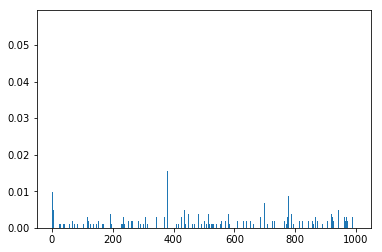

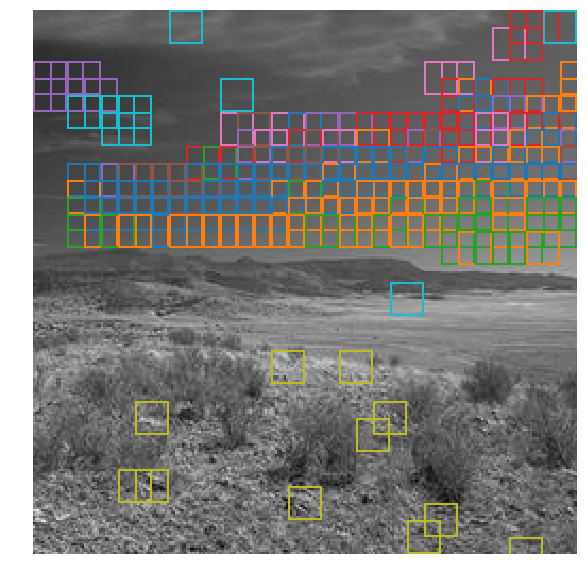

(9, 16, 16)


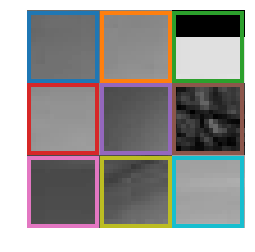

In [36]:
# Visualize your BoW on an image

iname = inames[2000]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)*255
reg = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=vdregions) # if you have vdregions, add it as input here